In [1]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import codecs
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import time
datasets_path = 'C:/Users/OptimusPrime/Desktop/Studia/NLP1/Natural-Language-Processing-1/Week 6/Data'

In [2]:
voc = dict()
with codecs.open(datasets_path + '\\odm.txt', 'r', 'utf-8') as f:
    text = f.read().lower() #read whole file to string
    lines = text.split('\r\n') #zwraca liste stringow(linii)
    for line in lines:
        words = np.array(line.split(', '))
        for word in words:
            voc[word] = words[0]

In [3]:
with codecs.open(datasets_path + '\\pap.txt', 'r', 'utf-8') as f:
    text = f.read().lower()
    preprocessed_text = re.sub(r'#\d+', '##', text)
    preprocessed_text = re.sub(r'\n', ' ', preprocessed_text)
    preprocessed_text = re.sub(r'[\\,.\-\'\"()?:;+\/\d+&`!\[\]@<>%*~{}=\x96\x84\x8c\x9c\x9f\x92\x80]', '', preprocessed_text)
    preprocessed_text = re.sub(r'[\xbc-\xff]', '', preprocessed_text)
    preprocessed_text = re.sub(r'   ', '  ', preprocessed_text)
    preprocessed_text = re.sub(r'  ', ' ', preprocessed_text)
    splitted_notes = np.array(preprocessed_text.split('##'))

In [4]:
def to_basic_form(matchobj):
    word = matchobj.group(0)
    if word in voc:
        return voc[word]
    else:
        return None


word_pattern = re.compile('\w+')
basic_form_notes = list()
for note in splitted_notes:
    basic_form_notes.append(word_pattern.sub(to_basic_form, note))

In [5]:
tf = TfidfVectorizer(max_df=3000, min_df=6, token_pattern='(?u)\\b\\w+\\b')
freq_matr = tf.fit_transform(basic_form_notes)
freq_matr

<51557x14317 sparse matrix of type '<class 'numpy.float64'>'
	with 1448452 stored elements in Compressed Sparse Row format>

In [6]:
frequency_matrix = freq_matr.toarray()
chosen_note = frequency_matrix[2634].astype(bool)

In [7]:
start = time.time()
dice_similarity_vector = [pairwise_distances([chosen_note, note], metric='dice')[0][1] for note in frequency_matrix.astype(bool)]
print("Time:" + str(time.time() - start))

Time:9.238804340362549


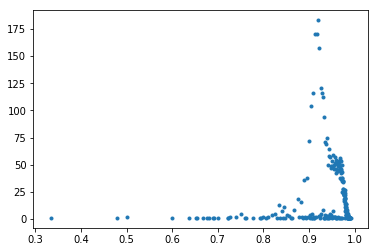

In [8]:
dice_distribution = Counter([metric for metric in dice_similarity_vector if metric != 1.0 and metric != 0.0])
plt.scatter(list(dice_distribution.keys()), list(dice_distribution.values()), s=9)
plt.show()

In [9]:
indices = dict()
indices['tfidf'] = list()
indices['graph3'] = list()
indices['graph4'] = list()
indices['graph5'] = list()
indices['LDA'] = list()
for i in range(len(dice_similarity_vector)):
    if dice_similarity_vector[i] < 0.80:
        indices['tfidf'].append(i)
print("Number of similar notes: " + str(len(indices['tfidf'])))

Number of similar notes: 31


In [10]:
cv = CountVectorizer(max_df=3000, min_df=6, token_pattern='(?u)\\b\\w+\\b')
cv_freq_matrix = cv.fit_transform(basic_form_notes)
words = cv.get_feature_names()
occurence_number = cv_freq_matrix.sum(axis=0).A1
len(cv.stop_words_)
stop_list = cv.stop_words_

In [11]:
occurence_number, words = (list(t) for t in zip(*sorted(zip(occurence_number, words), reverse=True)))

In [12]:
cv_freq_matrix

<51557x14317 sparse matrix of type '<class 'numpy.int64'>'
	with 1448452 stored elements in Compressed Sparse Row format>

In [13]:
def delete_banned_words(matchobj):
    word = matchobj.group(0)
    if word.lower() in banned_words:
        return ""
    else:
        return word

banned_words = stop_list
word_pattern = re.compile('\w+')
graph_notes = list()
for sentence in basic_form_notes:
    graph_notes.append(word_pattern.sub(delete_banned_words, sentence).split())    

In [14]:
encoder= {k: v for (k, v) in zip(words, range(len(words)))}

In [15]:
def transform_from_words_note_to_graph_vector(graph_note, n):
    note_matrix_dict = defaultdict(int)
    note_len = len(graph_note)
    if note_len == n-4 or note_len == n-3 or note_len == n-2 or note_len == n-1:
        return defaultdict(int)
    for i in range(note_len):
        if i == note_len - (n -1):
            break;  
        for j in range(n-1):
            note_matrix_dict[(encoder[graph_note[i]], encoder[graph_note[i+1+j]])] += 1
    return note_matrix_dict

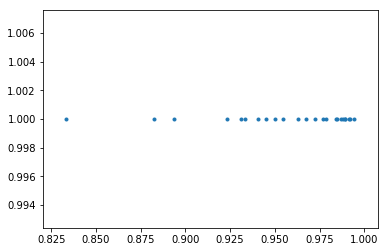

In [16]:
chosen_note = transform_from_words_note_to_graph_vector(graph_notes[2634], 3)
dice_metric = list()
for note in graph_notes:
    test_note = transform_from_words_note_to_graph_vector(note, 3)
    X_Y = 0
    X = len(test_note)
    Y = len(chosen_note)
    for key in chosen_note:
        if key in test_note:
            X_Y += 1
    dice_metric.append(1-(2*X_Y/(X+Y)))

dice_distribution = Counter([metric for metric in dice_metric if metric != 1.0 and metric != 0.0])
plt.scatter(list(dice_distribution.keys()), list(dice_distribution.values()), s=9)
plt.show()

In [17]:
for i in range(len(dice_metric)):
    if dice_metric[i] < 0.9999:
        indices['graph3'].append(i)
print("Number of similar notes: " + str(len(indices['graph3'])))

Number of similar notes: 25


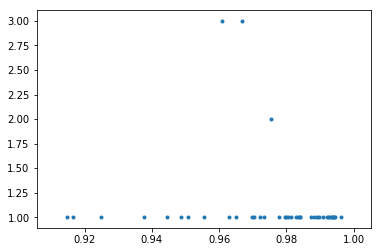

In [18]:
chosen_note = transform_from_words_note_to_graph_vector(graph_notes[2634], 4)
dice_metric = list()
for note in graph_notes:
    test_note = transform_from_words_note_to_graph_vector(note, 4)
    X_Y = 0
    X = len(test_note)
    Y = len(chosen_note)
    for key in chosen_note:
        if key in test_note:
            X_Y += 1
    dice_metric.append(1-(2*X_Y/(X+Y)))

dice_distribution = Counter([metric for metric in dice_metric if metric != 1.0 and metric != 0.0])
plt.scatter(list(dice_distribution.keys()), list(dice_distribution.values()), s=9)
plt.show()

In [19]:
for i in range(len(dice_metric)):
    if dice_metric[i] < 0.9999:
        indices['graph4'].append(i)
print("Number of similar notes: " + str(len(indices['graph4'])))

Number of similar notes: 46


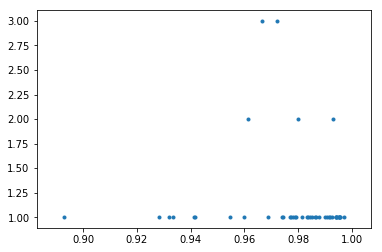

In [20]:
chosen_note = transform_from_words_note_to_graph_vector(graph_notes[2634], 5)
dice_metric = list()
for note in graph_notes:
    test_note = transform_from_words_note_to_graph_vector(note, 5)
    X_Y = 0
    X = len(test_note)
    Y = len(chosen_note)
    for key in chosen_note:
        if key in test_note:
            X_Y += 1
    dice_metric.append(1-(2*X_Y/(X+Y)))

dice_distribution = Counter([metric for metric in dice_metric if metric != 1.0 and metric != 0.0])
plt.scatter(list(dice_distribution.keys()), list(dice_distribution.values()), s=9)
plt.show()

In [21]:
for i in range(len(dice_metric)):
    if dice_metric[i] < 0.9999:
        indices['graph5'].append(i)
print("Number of similar notes: " + str(len(indices['graph5'])))

Number of similar notes: 52


In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=5)
reduced_freq_matr = svd.fit_transform(freq_matr)

In [23]:
chosen_note = reduced_freq_matr[2634]

In [24]:
start = time.time()
dice_similarity_vector = [cosine_similarity([chosen_note, note])[0][1] for note in reduced_freq_matr]
print("Time:" + str(time.time() - start))

Time:6.550711393356323


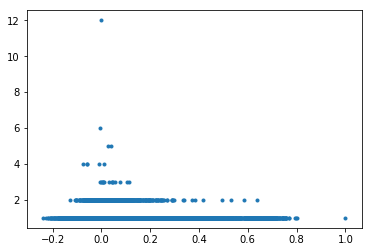

In [25]:
dice_distribution = Counter([metric for metric in dice_similarity_vector])
plt.scatter(list(dice_distribution.keys()), list(dice_distribution.values()), s=9)
plt.show()

In [26]:
indices['LDA'] = list()
for i in range(len(dice_similarity_vector)):
    if dice_similarity_vector[i] > 0.70:
        indices['LDA'].append(i)
print("Number of similar notes: " + str(len(indices['LDA'])))

Number of similar notes: 56


In [27]:
all_indices = set()
for key in indices:
    for val in indices[key]:
        all_indices.add(val)


In [28]:
all_indices

{102,
 1540,
 1866,
 1938,
 2219,
 2634,
 3468,
 3470,
 3590,
 3690,
 4087,
 4989,
 5087,
 5955,
 7411,
 7529,
 7756,
 8056,
 8168,
 9911,
 10108,
 11089,
 11197,
 11708,
 12049,
 12200,
 12515,
 12712,
 13756,
 13853,
 14917,
 16193,
 17294,
 17458,
 17486,
 17574,
 18080,
 18345,
 18346,
 18474,
 18814,
 19409,
 20716,
 20811,
 20894,
 21231,
 21422,
 21515,
 21976,
 22062,
 22288,
 23562,
 23563,
 23646,
 23867,
 23948,
 23960,
 25089,
 25225,
 25325,
 25562,
 26103,
 26856,
 27012,
 27095,
 27184,
 27391,
 27403,
 27880,
 27993,
 28753,
 29297,
 29632,
 30417,
 31016,
 32331,
 33566,
 34520,
 34622,
 37385,
 37523,
 37754,
 37891,
 37911,
 38016,
 38018,
 38179,
 38420,
 38523,
 38666,
 39034,
 39274,
 40125,
 40130,
 40773,
 42268,
 44751,
 45970,
 46545,
 46936,
 46937,
 47027,
 47796,
 48030,
 48271,
 48328,
 48370,
 48556,
 48672,
 48673,
 48992,
 49798}

In [29]:
for i, ind in zip(range(len(all_indices)), all_indices):
    print('\n'+' ' + str(i) + ' ' + splitted_notes[ind])


 0  aby osiągnąć na szczycie unii europejskiej w nicei europejskie porozumienie niemcy gotowe są do kompromisw w istotnych sprawach oświadczyły koła rządowe w berlinie mamy fundamentalny interes w tym aby nicea zakończyła się sukcesem powiedział przedstawiciel niemieckiego rządu niemcy nie będą demonstrować siły ani też szukać konfrontacji zapewnił koła rządowe w berlinie przyznają że kraje unii nie osiągnęły jeszcze porozumienia w wielu istotnych kwestiach jako trudne problemy wymieniono liczbę członkw komisji europejskiej rozdział głosw w radzie ue pomiędzy poszczeglne państwa oraz przejście od dotychczasowej zasady jednomyślności do podejmowania decyzji większością głosw z zapowiedzi niemieckiego rządu wynika że berlin gotowy jest do rezygnacji z jednego komisarza obecnie dwaj komisarze to niemcy oraz w przypadku wprowadzenia zasady rotacji do czasowej rezygnacji z obecności w komisji 

 1  załoga wahadłowca endeavour ktry w sobotę zacumował do międzynarodowej stacji kosmicznej iss

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
y = np.array([[i in indices['tfidf'], i in indices['graph3'], i in indices['graph4'], i in indices['graph5'], i in indices['LDA'], True] for i in all_indices])

false_notes = [0,2,16,30,37,39,40,43,45,49,51,57,60,77,78,85,92,97,100]
for f in false_notes:
    y[f][5] = False
y
    

array([[False, False, False,  True, False, False],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True, False],
       [False, False, False, False,  True,  True],
       [ True, False,  True,  True, False,  True],
       [False, False,  True,  True, False,  True],
       [ True, False, False, False, False,  True],
       [False, False,  True,  True, False,  True],
       [ True, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [ True,  True,  True,  True, False,  True],
       [False, False,  True,  True, False,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False,  True, False,  True],
       [False, False, False, False,  True,  True],
       [False,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [False, False, False,  T

In [31]:
models = ['TfIdf', 'Graph - 3', 'Graph - 4', 'Graph - 5', 'LDA']
for i in range(len(y[0]) - 1):
    print(models[i])
    print('Precision: ' + str(precision_score(y[:, 5], y[:, i])))
    print('Recall: ' + str(recall_score(y[:, 5], y[:, i])))
    print('F1: ' + str(f1_score(y[:, 5], y[:, i])))
    print('')

TfIdf
Precision: 1.0
Recall: 0.3333333333333333
F1: 0.5

Graph - 3
Precision: 0.68
Recall: 0.1827956989247312
F1: 0.288135593220339

Graph - 4
Precision: 0.717391304347826
Recall: 0.3548387096774194
F1: 0.4748201438848921

Graph - 5
Precision: 0.7307692307692307
Recall: 0.40860215053763443
F1: 0.5241379310344828

LDA
Precision: 0.9285714285714286
Recall: 0.5591397849462365
F1: 0.6979865771812079

